In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader 
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import wandb
import math
import argparse
import datetime
import math
from time import time

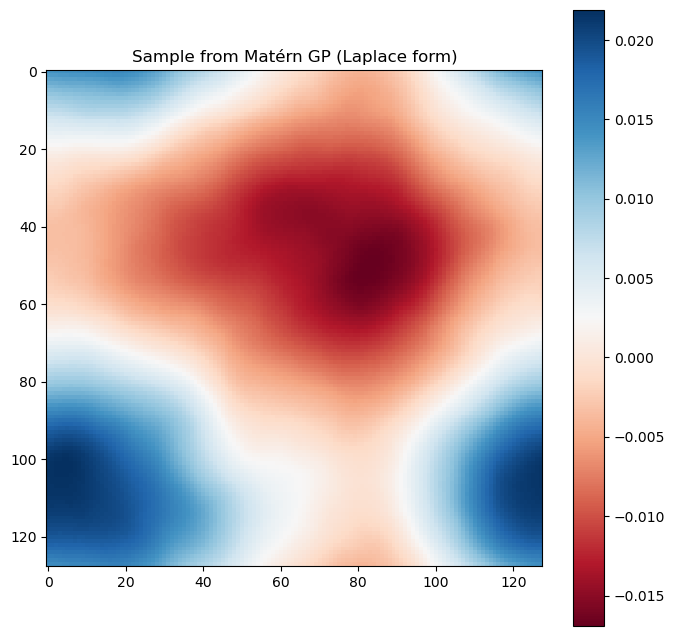

tensor(7.2577e-05)

In [2]:
# generating Gaussian measure on torus; diagonizable in Fourier

def generate_matern_laplace(num_samples, grid_size, sigma_sq=1.0, length_scale=1.0, s=2.0, seed=None):
    """
    Generate Matérn GP using the operator form σ²(-Δ + l²I)^{-s}
    
    Args:
        grid_size (int): Size of the grid (N x N)
        sigma_sq (float): Variance parameter σ²
        length_scale (float): Length scale l
        s (float): Smoothness parameter s
        seed (int): Random seed for reproducibility
    
    Returns:
        torch.Tensor: Sample from the GP
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate frequency grid (scaled by 2π)
    freq = torch.fft.fftfreq(grid_size) * 2 * math.pi * grid_size
    freq_x, freq_y = torch.meshgrid(freq, freq, indexing='ij')
    
    # Compute -Laplacian in Fourier space: |k|²
    laplacian = freq_x**2 + freq_y**2
    
    # Compute spectral density: σ²(|k|² + l²)^{-s}
    spectral_density = sigma_sq * (laplacian + length_scale**2)**(-s)
    spectral_density[0,0] = 0
    spectral_density = spectral_density.unsqueeze(0)  # adding 1 dim
    
    # Generate complex Gaussian noise
    noise_real = torch.randn(num_samples, grid_size, grid_size)
    noise_imag = torch.randn(num_samples, grid_size, grid_size)
    noise = noise_real + 1j * noise_imag
    
    # Apply sqrt of spectral density
    spectral_sample = torch.sqrt(spectral_density) * noise
    
    # Transform back to spatial domain
    sample = torch.fft.ifft2(spectral_sample, norm='forward')
    sample = sample.real
    
    return sample

def plot_sample(sample):
    """Plot a sample from the GP"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 8))
    plt.imshow(sample.numpy(), cmap='RdBu')
    plt.colorbar()
    plt.title('Sample from Matérn GP (Laplace form)')
    plt.show()

# Example usage

grid_size = 128
sample = generate_matern_laplace(
    num_samples=1000,
    grid_size=grid_size,
    sigma_sq=1,
    length_scale=1.0,
    s=3,
    seed=42
)

# Plot the sample
plot_sample(sample[0,...])
# (sample[:,...]**2).mean()

spatial_variance = (sample**2).mean(dim=(1, 2))
spatial_variance.mean()

In [11]:
#### scaled interpolants

# base
ls0 = 1
s0 = 0
sigma_sq0 =  ((2*np.pi)**2 + ls0**2)**s0
param0 = [sigma_sq0, ls0, s0]

# target
ls1 = 1
s1 = 3
sigma_sq1 = 1 * ((2*np.pi)**2 + ls1**2)**s1
param1 = [sigma_sq1, ls1, s1]

grid_size = 128
freq = torch.fft.fftfreq(grid_size) * 2 * math.pi * grid_size
freq_x, freq_y = torch.meshgrid(freq, freq, indexing='ij')
laplacian = freq_x**2 + freq_y**2
# Compute spectral density: σ²(|k|² + l²)^{-s}
spectral_density0 = sigma_sq0 * (laplacian + ls0**2)**(-s0)
spectral_density1 = sigma_sq1 * (laplacian + ls1**2)**(-s1)
ratio = spectral_density1[grid_size//2,grid_size//2]/spectral_density0[grid_size//2,grid_size//2]



# ratio = np.exp(1)
print(ratio)


# scalar interpolant
def alpha(t):
    return np.sqrt((ratio - ratio**t)/(ratio - 1))

def alpha_dot(t):
    return -0.5*1/alpha(t)*(ratio**t)*np.log(ratio)/(ratio - 1)
    
def beta(t):
    return np.sqrt((ratio**t - 1)/(ratio - 1))

def beta_dot(t):
    return 0.5*1/beta(t)*(ratio**t)*np.log(ratio)/(ratio - 1)


tensor(1.9607e-12)


/state/partition1/job-62375410/ipykernel_1046553/3544171911.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((ratio - ratio**t)/(ratio - 1))
/state/partition1/job-62375410/ipykernel_1046553/3544171911.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((ratio**t - 1)/(ratio - 1))


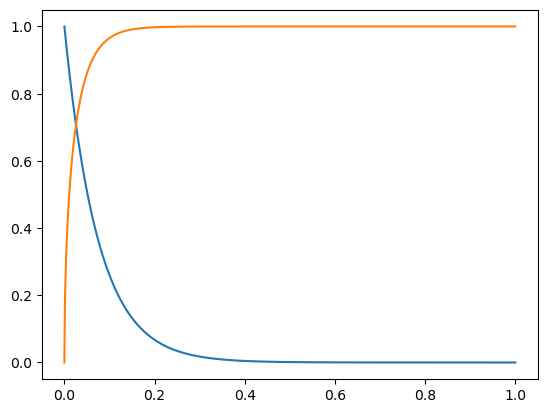

In [12]:
### show figures of alpha, beta

tmp_t = np.linspace(0,1,1000)
alpha_t = [alpha(t) for t in tmp_t]

plt.plot(tmp_t, alpha_t)
beta_t = [beta(t) for t in tmp_t]

plt.plot(tmp_t, beta_t)

In [13]:
# drift

def drift_b(z, t, param0, param1, grid_size):
    """
    get the analytic formula for the drift
    
    Args:
        grid_size (int): Size of the grid (N x N)
    
    Returns:
        drift: size (batch, channel, N, N)
    """    

    freq = torch.fft.fftfreq(grid_size) * 2 * math.pi * grid_size
    freq_x, freq_y = torch.meshgrid(freq, freq, indexing='ij')
    laplacian = freq_x**2 + freq_y**2

    sigma_sq0, ls0, s0 = param0
    sigma_sq1, ls1, s1 = param1
    
    # Compute spectral density: σ²(|k|² + l²)^{-s}
    spectral_density0 = sigma_sq0 * (laplacian + ls0**2)**(-s0)
    spectral_density1 = sigma_sq1 * (laplacian + ls1**2)**(-s1)
    spectral_density0 = spectral_density0[None,...]
    spectral_density1 = spectral_density1[None,...]

    
    da = alpha_dot(t)
    a = alpha(t)
    db = beta_dot(t)
    b = beta(t)

    spectral_ratio = (a*da*spectral_density0 + b*db*spectral_density1)/(a**2*spectral_density0 + b**2*spectral_density1)
    xfft = torch.fft.fft2(z, dim=(1,2), norm='forward')
    out = torch.fft.ifft2(spectral_ratio * xfft, dim=(1,2), norm='forward').real
    return out

In [14]:

z0 = generate_matern_laplace(
    num_samples=2000,
    grid_size=grid_size,
    sigma_sq=param0[0],
    length_scale=param0[1],
    s=param0[2],
    seed=42
)

z1 = generate_matern_laplace(
    num_samples=2000,
    grid_size=grid_size,
    sigma_sq=param1[0],
    length_scale=param1[1],
    s=param1[2],
    seed=45
)

D = {'z0': z0, 'z1': z1}

t_min_sample = 1e-4
t_max_sample = 1-1e-4


In [15]:
#### EM integration

# def EM(D, t_min_sample, t_max_sample, param0, param1, grid_size, steps = 200): 
#     print('[Sampler] Use EM samplers')
#     init_condition = D['z0']
#     tgrid = torch.linspace(t_min_sample, t_max_sample, steps)
#     dt = tgrid[1] - tgrid[0]
#     zt = D['z0']
#     ones = torch.ones(zt.shape[0]).type_as(zt)
#     for t in tgrid:
#         f = drift_b(zt, t, param0, param1, grid_size) 
#         zt_mean = zt + f * dt
#         zt = zt_mean
#     return zt_mean

# out = EM(D, t_min_sample, t_max_sample, param0, param1, grid_size, steps = 200)

In [16]:
### RK integration

from torchdiffeq import odeint
class PFlowRHS(nn.Module):
    def __init__(self, drift_b, param0, param1, grid_size):
        super(PFlowRHS, self).__init__()
        self.drift_b = drift_b
        self.param0 = param0
        self.param1 = param1
        self.grid_size = grid_size
        
    def forward(self, t, states):
        (zt,) = states
        dzt = self.drift_b(zt, t, self.param0, self.param1, self.grid_size)
        return (dzt,)
             
class PFlowIntegrator:
        
    def __init__(self):
        return        

    def __call__(self, drift_b, z0, param0, param1, grid_size, T_min, T_max, steps, method='dopri5', return_last = True):

        rhs = PFlowRHS(drift_b, param0, param1, grid_size)

        t = torch.linspace(
            T_min, T_max, steps
        ).type_as(z0)

        int_args = {
            'method': method, 
            # 'atol': c.integration_atol, 
            # 'rtol': c.integration_rtol,
        }

        (z,) = odeint(rhs, (z0,), t, **int_args)
        if return_last:
            return z[-1]
        else:
            return z

pflow = PFlowIntegrator()
out = pflow(
    drift_b = drift_b,
    z0 = D['z0'],
    param0 = param0, 
    param1 = param1, 
    grid_size = grid_size,
    T_min = t_min_sample,
    T_max = t_max_sample,
    steps = 20,
    method = 'rk4',
    return_last = True,)

/state/partition1/job-62375410/ipykernel_1046553/3544171911.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((ratio - ratio**t)/(ratio - 1))
/state/partition1/job-62375410/ipykernel_1046553/3544171911.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -0.5*1/alpha(t)*(ratio**t)*np.log(ratio)/(ratio - 1)
/state/partition1/job-62375410/ipykernel_1046553/3544171911.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((ratio**t - 1)/(ratio - 1))
/state/partition1/job-62375410/ipykernel_1046553/3544171911.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 0.5*1/beta(t)*(ratio**t

In [17]:
### compute spectrum

import scipy.stats as stats
def get_Fourier_spectrum(data):
    data_hat = torch.fft.fftn(data,dim=(1,2),norm = "forward")
    fourier_amplitudes = np.abs(data_hat)**2
    fourier_amplitudes = fourier_amplitudes.mean(dim=0)
    npix = data_hat.shape[-1]
    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins_w, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
    Abins_w *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    
    return kvals, Abins_w


In [18]:
## mean error
# ((out**2).mean() - (z1**2).mean()).abs()/(z1**2).mean()

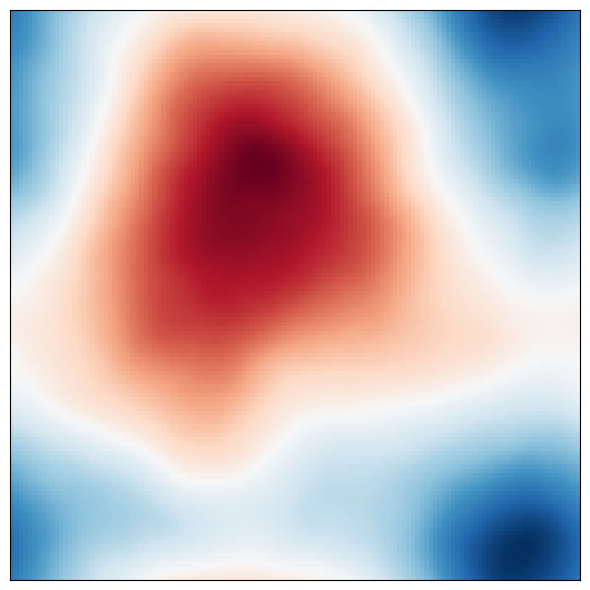

In [21]:

plt.figure(figsize=(6, 6))
plt.imshow(out[0,...].numpy(), cmap='RdBu')

# Create colorbar with smaller size and no tick labels
# cbar = plt.colorbar(shrink=0.6)  # shrink makes it smaller (0.6 = 60% of original size)
# cbar.set_ticks([])  # removes the numbers on the colorbar

# Optional: also remove axis numbers from the main plot
plt.xticks([])  # removes x-axis numbers
plt.yticks([])  # removes y-axis numbers

plt.tight_layout()
plt.savefig("Gaussian-res128-sample-designed-schedule-RK20.pdf", dpi=300)

/state/partition1/job-62367954/ipykernel_2630934/1229542153.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fourier_amplitudes = np.abs(data_hat)**2


0.014657681238270123


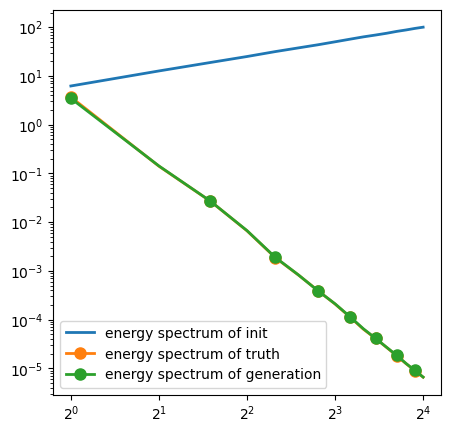

In [31]:
kvals, Abins_w0 = get_Fourier_spectrum(z0)
kvals, Abins_w1 = get_Fourier_spectrum(z1)
kvals, Abins_w2 = get_Fourier_spectrum(out)

fig = plt.figure(figsize=(5,5))
plt.plot(kvals, Abins_w0, linewidth=2,label = 'energy spectrum of init')
plt.plot(kvals, Abins_w1, linewidth=2, marker='o', markersize=8, markevery=2, label = 'energy spectrum of truth')
plt.plot(kvals, Abins_w2, linewidth=2, marker='o', markersize=8, markevery=2, label = 'energy spectrum of generation')
plt.xscale('log', base = 2)
plt.yscale('log')
plt.legend()

print(np.mean(np.abs(Abins_w1 - Abins_w2)))

In [38]:
# torch.save(Abins_w2, "Gaussian-res128-scaled-schedule-RK20.pt")

In [49]:
# torch.save(Abins_w1, "Gaussian-res128-truth.pt")
# torch.save(kvals, "Gaussian-res128-kvals.pt")
# torch.save(Abins_w0, "Gaussian-res128-init.pt")

In [32]:
Abins_w1

array([3.69538235e+00, 1.40565629e-01, 2.68681402e-02, 6.64868965e-03,
       1.86388036e-03, 8.20486420e-04, 3.91582815e-04, 2.08900739e-04,
       1.12762766e-04, 6.35232405e-05, 4.11499082e-05, 2.69363501e-05,
       1.81173057e-05, 1.24488936e-05, 8.95221271e-06, 6.60070015e-06])

In [33]:
Abins_w2

array([3.46267836e+00, 1.42217694e-01, 2.69314247e-02, 6.70875830e-03,
       1.89336497e-03, 8.24951024e-04, 3.88545478e-04, 2.11159544e-04,
       1.14653334e-04, 6.48697735e-05, 4.13963618e-05, 2.71154843e-05,
       1.84708556e-05, 1.25409179e-05, 9.05809644e-06, 6.63092580e-06])